<center>
<h1>Training and Tuning</h1>
</center>

<hr>

Once you are done here, you are ready to start playing with your server. Cool.

In [ ]:
github_name = 'attajunyah'
repo_name = 'cis523'
source_file = 'library.py'
url = f'https://raw.githubusercontent.com/{github_name}/{repo_name}/main/{source_file}'
!rm $source_file
!wget $url
%run -i $source_file

--2022-12-06 00:39:47--  https://raw.githubusercontent.com/attajunyah/cis523/main/library.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12562 (12K) [text/plain]
Saving to: ‘library.py’

library.py          100%[===================>]  12.27K  --.-KB/s    in 0.001s  

2022-12-06 00:39:47 (18.2 MB/s) - ‘library.py’ saved [12562/12562]



#cmd-m y to turn this into code cell, cmd-m m to go other way
%%capture
!pip install uo-puddles
from uo_puddles.cis423 import *

#Below is copied from your wrangling notebook

You need to replace my Pima code with your own.

In [ ]:
url = 'https://raw.githubusercontent.com/attajunyah/cis523/main/raw_data.csv'  #from github
credit_df = pd.read_csv(url)
credit_df['Loan_Status'] = credit_df['Loan_Status'].replace({'Yes':1, 'No':0}).to_list()  
credit_df.head()

,Age,Income,Home_Status,Employment_Length,Loan_Intent,Loan_Grade,Loan_Amount,Interest_Rate,Loan_Status,Loan_Income_Percent,Historical_Default,Credit_History
0,26,65600,RENT,5.0,EDUCATION,D,10000,13.55,1,0.15,Y,2
1,40,41000,MORTGAGE,2.0,HOMEIMPROVEMENT,C,6000,12.53,0,0.15,N,11
2,26,25000,RENT,0.0,PERSONAL,D,2400,15.28,1,0.10,Y,3
3,23,22000,RENT,1.0,EDUCATION,C,5500,13.04,0,0.25,N,4
4,22,75000,RENT,2.0,VENTURE,C,7200,13.61,0,0.10,N,4


#I. Copy pipeline from Wrangling notebook

Replace mine below with your own.

In [ ]:
credit_transformer = Pipeline(steps=[
    ('drop', DropColumnsTransformer(['Home_Status'], 'drop')),
    ('loan_grade', MappingTransformer('Loan_Grade', {'A': 0, 'B': 1, 'C': 2, 
                                                     'D': 3, 'E': 4, 'F': 5,
                                                     'G': 6})),
    ('hist_def', MappingTransformer('Historical_Default', {'N': 0, 'Y': 1})),
    ('ohe', OHETransformer(target_column='Loan_Intent')),
    ('age', TukeyTransformer('Age', 'outer')),
    ('income', TukeyTransformer('Income', 'outer')),
    ('emp_len', TukeyTransformer('Employment_Length', 'outer')),
    ('loan', TukeyTransformer('Loan_Amount', 'outer')),
    ('interest', TukeyTransformer('Interest_Rate', 'outer')),
    ('loan_income_ratio', TukeyTransformer('Loan_Income_Percent', 'outer')),
    ('credit_hist', TukeyTransformer('Credit_History', 'outer')),
    ('scale', MinMaxTransformer()), 
    ('imputer', KNNTransformer())
    ], verbose=True)


##Replace values of mine with your own below

In [ ]:
%%capture
rs = 28  #got this from wrangling notebook
ts = .4  #you may have to make this larger depending on what happened in wrangling notebook
x_trained, x_test, y_train, y_test = dataset_setup(credit_df, 'Loan_Status', credit_transformer, rs=rs, ts=ts)  #change for your own dataset

##SMOTE variations to consider

Note that there are now some variations of SMOTE that combine upsampling with downsampling. This [article](https://towardsdatascience.com/stop-using-smote-to-handle-all-your-imbalanced-data-34403399d3be) gives you the background. Really easy. Just replace SMOTE with SMOTETomek or SMOTEENN.

In [ ]:
!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
smote = SMOTE(random_state=1234)  #or SMOTETomek(random_state=1234) or SMOTEENN(random_state=1234)
x_trained_up, y_train_up = smote.fit_resample(x_trained, y_train)

In [ ]:
len(x_trained_up)  #we added roughly 200 new rows

7976

In [ ]:
sum(y_train_up)/len(y_train_up)  #and we went from 65/35 to 50/50

0.5

#II. Tackle KNN first

Choose your grid, run HalvingSearchCV, train best model, save model and results_df.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_grid = dict(n_neighbors=range(5,100,10),
                weights=('uniform', 'distance'),
                algorithm=('auto', 'ball_tree', 'kd_tree', 'brute'),
                p=(1,2)
)

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
knn_model = KNeighborsClassifier()

In [ ]:
%%capture

#do the grid search
halving_cv = HalvingGridSearchCV(
    knn_model, knn_grid,  #our model and the parameter combos we want to try
    scoring="roc_auc",  #could alternatively choose f1, accuracy or others
    n_jobs=-1,
    min_resources="exhaust",
    factor=3,  #a typical place to start so triple samples and take top 3rd of combos on each iteration
    cv=5, random_state=1234,
    refit=True,  #remembers the best combo and gives us back that model already trained and ready for testing
)

grid_result = halving_cv.fit(x_trained_up, y_train_up)


In [ ]:
grid_result.best_params_  

{'algorithm': 'ball_tree', 'n_neighbors': 75, 'p': 1, 'weights': 'distance'}

In [ ]:
best_knn_model = grid_result.best_estimator_
best_knn_model.score(x_test,y_test)

0.7844117647058824

In [ ]:
yraw = best_knn_model.predict_proba(x_test)[:,1]

In [ ]:
result_df, fancy_df = threshold_results(np.round(np.arange(0.0,1.01,.05), 2), y_test, yraw)
fancy_df

,threshold,precision,recall,f1,accuracy
0,0.00,0.22,1.00,0.36,0.22
1,0.05,0.24,1.00,0.39,0.31
2,0.10,0.26,0.99,0.41,0.37
3,0.15,0.28,0.98,0.43,0.44
4,0.20,0.30,0.96,0.46,0.51
5,0.25,0.33,0.94,0.49,0.56
6,0.30,0.35,0.92,0.51,0.62
7,0.35,0.38,0.89,0.53,0.66
8,0.40,0.41,0.84,0.55,0.70
9,0.45,0.46,0.80,0.58,0.75


In [ ]:
result_df.to_csv('knn_thresholds.csv', index=False)

In [ ]:
from joblib import dump
dump(best_knn_model, 'knn_model.joblib')

['knn_model.joblib']

#III. Logistic Regression next

##I'm doing some work for you

The problem is that not all combos make sense. So I did an analysis of which ones do make sense together and built 3 separated grids. The cool thing is that I can put them in a list and HalvingSearch will accept them!

In [ ]:
penalty_L2 = dict( 
                penalty=['l2'],                              
                solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                max_iter=range(50,1000,50),
                class_weight=['balanced', None]
)

penalty_L1 = dict(
                penalty=['l1'],
                solver=['liblinear', 'saga'],
                max_iter=range(50,1000,50),
                class_weight=['balanced', None]
)

penalty_elasticnet = dict(
                penalty=['elasticnet'],
                solver=['saga'],
                max_iter=range(50,1000,50),
                class_weight=['balanced', None],
                l1_ratios=[[0.2], [0.5], [0.8]]
)

grids = [penalty_L1, penalty_L2, penalty_elasticnet]  #I can put separate grids in a list - cool

##Go ahead and find best model, train, save results.

`HavlingSearchCV` will take `grids` as a legal argument.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
logreg_model = LogisticRegressionCV()

In [ ]:
grid_result = halving_search(model=logreg_model, grid=grids, x_train=x_trained_up, y_train=y_train_up)

In [ ]:
grid_result.best_params_  #{'class_weight': 'balanced', 'max_iter': 450, 'penalty': 'l1', 'solver': 'liblinear'}

{'class_weight': 'balanced',
 'max_iter': 350,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [ ]:
best_logreg_model = grid_result.best_estimator_
best_logreg_model.score(x_test,y_test)
yraw = best_logreg_model.predict_proba(x_test)[:,1]
result_df, fancy_df = threshold_results(np.round(np.arange(0.0,1.01,.05), 2), y_test, yraw)
fancy_df

,threshold,precision,recall,f1,accuracy
0,0.00,0.22,1.00,0.36,0.22
1,0.05,0.23,1.00,0.37,0.28
2,0.10,0.26,0.98,0.41,0.39
3,0.15,0.29,0.96,0.45,0.48
4,0.20,0.32,0.94,0.48,0.55
5,0.25,0.35,0.92,0.51,0.61
6,0.30,0.38,0.90,0.53,0.66
7,0.35,0.40,0.87,0.55,0.69
8,0.40,0.43,0.83,0.57,0.72
9,0.45,0.46,0.80,0.59,0.75


In [ ]:
result_df.to_csv('logreg_thresholds.csv', index=False)

In [ ]:
from joblib import dump
dump(best_logreg_model, 'logreg_model.joblib')

['logreg_model.joblib']

#IV. XGBoost next

Choose your grid, search, train, save results.

###One note: took about 20 minutes on Pima table

Which has only 600 rows. If you have n times that number of rows (e.g., 2x) you can estimate you will take n times as long (e.g., 40 minutes).

Maybe set it going and go have lunch.

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=1234)

xgb_grid = {
    "n_estimators": range(10,201,10),  #number of trees
    "max_depth": range(1,15),              #max tree depth
    "learning_rate": [0.1, 0.2, 0.3, 0.4],
    # "subsample": [.25, .5, 0.75],  # Fix subsample
    "booster": ['dart', 'gbtree', 'gblinear'],
}

In [ ]:
%%capture

grid_result = halving_search(xgb_model, xgb_grid, x_trained_up, y_train_up)
best_model = grid_result.best_estimator_

In [ ]:
best_model.score(x_test, y_test)  #

0.8752941176470588

In [ ]:
grid_result.best_params_ 

{'booster': 'gbtree',
 'learning_rate': 0.3,
 'max_depth': 3,
 'n_estimators': 170}

In [ ]:
yraw = best_model.predict_proba(x_test)[:,1]
result_df, fancy_df = threshold_results(np.round(np.arange(0.0,1.01,.05), 2), y_test, yraw)
fancy_df

,threshold,precision,recall,f1,accuracy
0,0.00,0.22,1.00,0.36,0.22
1,0.05,0.30,0.97,0.45,0.49
2,0.10,0.36,0.92,0.52,0.63
3,0.15,0.42,0.87,0.57,0.71
4,0.20,0.49,0.83,0.62,0.78
5,0.25,0.55,0.80,0.65,0.81
6,0.30,0.59,0.78,0.67,0.84
7,0.35,0.63,0.76,0.69,0.85
8,0.40,0.68,0.75,0.71,0.87
9,0.45,0.70,0.73,0.72,0.87


In [ ]:
result_df.to_csv('xgb_thresholds.csv', index=False)

In [ ]:
from joblib import dump
dump(best_model, 'xgb_model.joblib') 

['xgb_model.joblib']

#V. ANN is last

Usual: define grid, search, train, save results. Look to chapter 13 Part 2 for details.


###One note: took about 10 minutes on Pima

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import tensorflow as tf
from tensorflow import keras

np.random.seed(seed=1234)
tf.random.set_seed(1234)

In [ ]:
feature_n = len(x_trained_up[0])  #how many features are we using?

act_fn='relu'
l2_regu = tf.keras.regularizers.L2(0.01)  #weight regularization 
initializer = tf.keras.initializers.HeNormal(seed=1234)  #works best with Relu: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/

ann_model = Sequential()  #we will always use this in our class. It means left-to-right and dense.

#hidden layer 1
ann_model.add(Dense(units=16, activation=act_fn, input_dim=feature_n, activity_regularizer=l2_regu, kernel_initializer=initializer))
ann_model.add(Dropout(.2))  #mitigates overfitting

#hidden layer 2
ann_model.add(Dense(units=8, activation=act_fn, activity_regularizer=l2_regu, kernel_initializer=initializer))
ann_model.add(Dropout(.4))

#hidden layer 3

#hidden layer 4

#etc

#output layer for binary classification
ann_model.add(Dense(units=1, activation='sigmoid'))  #only 1 node and using sigmoid (just like with logistic regression!)

loss_choice = tf.keras.losses.BinaryCrossentropy()  #https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)  #https://machinelearningknowledge.ai/keras-optimizers-explained-with-examples-for-beginners/
try:
  auc  #avoid instantiating twice - strange behavior
except:
  auc = tf.keras.metrics.AUC()
ann_model.compile(loss=loss_choice,
                  optimizer=optimizer,
            metrics = [auc]  #area under curve for performance
)

In [ ]:
# Train ANN
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=5,  #Wait 5 epochs for loss to change - if no change, stop
    verbose=0
)

In [ ]:
batch = 100
epochs = 30
training = ann_model.fit(x=x_trained_up,
                        y=y_train_up,
                         batch_size=batch,
                         epochs=epochs,
                         verbose=0,
                         callbacks=[early_stop_cb])

In [ ]:
batch, len(training.history['auc'])  #looks like yes

(100, 17)

In [ ]:
training.history['auc'][-1]

0.7628732323646545

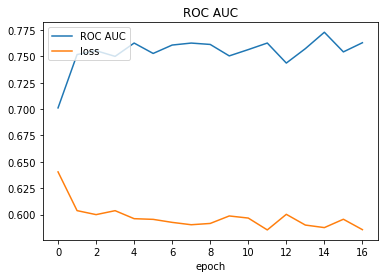

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training.history['auc'])
plt.plot(training.history['loss'])
plt.title('ROC AUC')
plt.xlabel('epoch')
plt.legend(['ROC AUC', 'loss'], loc='upper left')
plt.show()

In [ ]:
# Evaluate on Train Set
ann_model.predict(x_trained)[:5]


160/160 [==============================] - 1s 3ms/step


array([[0.44159892],
       [0.21620317],
       [0.3535052 ],
       [0.00047088],
       [0.3885956 ]], dtype=float32)

In [ ]:
yraw = ann_model.predict(x_trained)[:,0]  #pull out prob of 1
yraw[:5]

160/160 [==============================] - 1s 5ms/step


array([0.44159892, 0.21620317, 0.3535052 , 0.00047088, 0.3885956 ],
      dtype=float32)

In [ ]:
binary = [1 if y>.5 else 0 for y in yraw]  #use normal threshold of .5
sum([x==y for x,y in zip(binary,y_train)])/len(binary)

0.7690196078431373

In [ ]:
# Evaluate on Test Set
yraw = ann_model.predict(x_test)[:,0]  #replaces predict_proba
yraw[:5]

107/107 [==============================] - 0s 1ms/step


array([0.04023527, 0.5298188 , 0.41593722, 0.19551393, 0.4560438 ],
      dtype=float32)

In [ ]:
binary = [1 if y>.5 else 0 for y in yraw]  #use normal threshold of .5
sum([x==y for x,y in zip(binary,y_test)])/len(binary)

0.7591176470588236

In [ ]:
# Getting ready for tuning
np.random.seed(seed=1234)
tf.random.set_seed(1234)


In [ ]:
def ann_build_binary_model(*, n:int, architecture, metrics=auc, learning_rate=.02):
  assert isinstance(n, int), f'n is an int, the number of columns/features of each sample. Instead got {type(n)}'
  assert isinstance(architecture, list) or isinstance(architecture, tuple), f'architecture is a list or tuple, the number of nodes per layer. Instead got {type(architecture)}'
  assert architecture, f'architecture is empty'
  assert isinstance(architecture[0], list), f'architecture should be list of one or more lists but instead {architecture}'

  l2_regu = tf.keras.regularizers.L2(0.01)  #weight regularization during gradient descent
  initializer = tf.keras.initializers.HeNormal(seed=1234)  #works best with Relu: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/

  model = Sequential()

  #handle first hidden layer separately because of input_dim

  layer_units = architecture[0][0]
  layer_dropout = architecture[0][1]
  layer_act = architecture[0][2]
  model.add(Dense(units=layer_units, activation=layer_act, activity_regularizer=l2_regu, kernel_initializer=initializer, input_dim=n))  #first hidden layer needs number of inputs
  model.add(Dropout(layer_dropout))

  for layer in architecture[1:]:
    layer_units = layer[0]
    layer_dropout = layer[1]
    layer_act = layer[2]
    model.add(Dense(units=layer_units, activation=layer_act, activity_regularizer=l2_regu, kernel_initializer=initializer))
    model.add(Dropout(layer_dropout))
    
  #now output layer
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),  #hard code loss
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),  #hard code optimizer
              metrics=[metrics])
  return model


In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier  #this is the wrapper
model_builder = KerasClassifier(build_fn=ann_build_binary_model, verbose=0)  #we are now wrapped so can use sklearn

<ipython-input-53-5073b5031f63>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_builder = KerasClassifier(build_fn=ann_build_binary_model, verbose=0)  #we are now wrapped so can use sklearn


In [ ]:
from sklearn.model_selection import RandomizedSearchCV  #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [ ]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)

In [ ]:
af = 'PReLU'  #your choice after reading article

#layers I want to try
architecture_1 = [[16, .2, af]]
architecture_2 = [[16, .2, af], [8, .4, af]]  #one we tried above
architecture_3 = [[4, .2, af]]
#add 5 more archituctures
architecture_4 = [[512, .2, af], [256, .4, af], [128, .4, af]]
architecture_5 = [[512, .4, af], [256, .4,af], [128, .4, af], [64, .4, af], [32, .4, af]]
architecture_6 = [[512, .2, af], [256, .4, af]]
architecture_7 = [[512, .4, af], [256, .4, af], [128, .4, af], [64, .4, af]]
architecture_8 = [[256, .2, af], [128, .4, af], [64, .4, af]]
architecture_9 = [[128, .4, af], [64, .4, af]]
architecture_10 = [[64, .2, af], [32, .4,af]]
architecture_11 = [[32, .4, af]]


architectures = [architecture_1, architecture_2, architecture_3, architecture_4,
                 architecture_5, architecture_6, architecture_7, architecture_8,
                 architecture_9, architecture_10, architecture_11]  #add 5 more on to this list

#generating random numbers from range
learn_rate = np.random.uniform(low=1e-2, high=1e-4, size=5)  #generate 5 choices in low/high range
batch_size = np.random.randint(10,200,5)  #generate 5 choices between 10 and 200
epochs = np.random.randint(10,50,5)  #generate 5 choices between 10, 50

In [ ]:
#build your grid
param_grid = dict(n=[feature_n],
                  architecture=architectures,
                  batch_size=batch_size,
                  epochs=epochs,
                  learning_rate=learn_rate)

param_grid


{'n': [15],
 'architecture': [[[16, 0.2, 'PReLU']],
  [[16, 0.2, 'PReLU'], [8, 0.4, 'PReLU']],
  [[4, 0.2, 'PReLU']],
  [[512, 0.2, 'PReLU'], [256, 0.4, 'PReLU'], [128, 0.4, 'PReLU']],
  [[512, 0.4, 'PReLU'],
   [256, 0.4, 'PReLU'],
   [128, 0.4, 'PReLU'],
   [64, 0.4, 'PReLU'],
   [32, 0.4, 'PReLU']],
  [[512, 0.2, 'PReLU'], [256, 0.4, 'PReLU']],
  [[512, 0.4, 'PReLU'],
   [256, 0.4, 'PReLU'],
   [128, 0.4, 'PReLU'],
   [64, 0.4, 'PReLU']],
  [[256, 0.2, 'PReLU'], [128, 0.4, 'PReLU'], [64, 0.4, 'PReLU']],
  [[128, 0.4, 'PReLU'], [64, 0.4, 'PReLU']],
  [[64, 0.2, 'PReLU'], [32, 0.4, 'PReLU']],
  [[32, 0.4, 'PReLU']]],
 'batch_size': array([ 33, 164,  40, 181, 168]),
 'epochs': array([36, 38, 15, 26, 19]),
 'learning_rate': array([0.00810396, 0.00384112, 0.0056665 , 0.00222495, 0.00227824])}

In [ ]:
#build searcher_model and search
# searcher_model = RandomizedSearchCV(estimator=model_builder, n_jobs=1,  #errors with n_jobs=-1
#                               cv=5,  #does stratification by default
#                               verbose=1,
#                               n_iter=10, #number of random samples to try
#                               random_state=1234,
# 	                            param_distributions=param_grid,
#                               scoring="roc_auc")


In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)

#build searcher_model
searcher_model = RandomizedSearchCV(estimator=model_builder, n_jobs=1,  #errors with n_jobs=-1
                              cv=skf,  #making sure we get stratified!
                              verbose=1,
                              n_iter=10, #number of random samples to try
                              random_state=1234,
                                param_distributions=param_grid,
                              scoring="roc_auc")

In [ ]:
#your code to search, build model, train
searchResults = searcher_model.fit(x_trained_up, y_train_up, callbacks=[early_stop_cb])

searchResults.best_score_  #from training


Fitting 2 folds for each of 10 candidates, totalling 20 fits
125/125 [==============================] - 0s 1ms/step


0.9183196530413708

In [ ]:
bestParams = searchResults.best_params_
bestParams

{'n': 15,
 'learning_rate': 0.0022782394996238445,
 'epochs': 15,
 'batch_size': 164,
 'architecture': [[512, 0.2, 'PReLU'], [256, 0.4, 'PReLU']]}

In [ ]:
#train ann_model
training = ann_model.fit(x=x_trained_up,
                        y=y_train_up,
                         batch_size=bestParams['batch_size'],
                         epochs=bestParams['epochs'],
                         verbose=0,
                         callbacks=[early_stop_cb],
)

In [ ]:
#build ann_model
ann_model = ann_build_binary_model(n=bestParams['n'],
                                   architecture=bestParams['architecture'],
                                   learning_rate=bestParams['learning_rate'])

In [ ]:
training.history['auc'][-1]  #small decline

0.7718081474304199

In [ ]:
yraw = ann_model.predict(x_test)
result_df, fancy_df = threshold_results(np.linspace(0,1,19,endpoint=True), y_test, yraw)
fancy_df

107/107 [==============================] - 0s 2ms/step


,threshold,precision,recall,f1,accuracy
0,0.00,0.22,1.00,0.36,0.22
1,0.06,0.22,1.00,0.36,0.22
2,0.11,0.22,1.00,0.36,0.22
3,0.17,0.22,1.00,0.36,0.22
4,0.22,0.22,1.00,0.36,0.22
5,0.28,0.22,1.00,0.36,0.22
6,0.33,0.22,1.00,0.36,0.22
7,0.39,0.22,1.00,0.36,0.22
8,0.44,0.22,1.00,0.36,0.22
9,0.50,0.22,0.99,0.37,0.25


###Save to local storage

In [ ]:
result_df.to_csv('ann_thresholds.csv', index=None)
ann_model.save('ann_model')

#You should know have 8 files on local Colab drive

Your goal is to move all files (excluding `sample_data`) to github. Notice that the `ann_model` is actually a folder. So zip it before moving to github.

<img src='https://www.dropbox.com/s/6stocy88ayd7w7m/Screen%20Shot%202022-02-24%20at%203.27.59%20PM.png?raw=1' height=300>